## Data Pipeline

This notebook outlines the data pipeline used to prepare climate reanalysis data for drought forecasting using deep learning models. Specifically, it processes ERA5 climate variables and Standardized Precipitation-Evapotranspiration Index (SPEI) values into a structured format suitable for training spatiotemporal models such as Convolutional LSTM (ConvLSTM) networks.

In [ ]:
!pip install cdsapi

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.0 MB/s eta 0:00:00


In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 130.5 MB/s eta 0:00:00


# Setup Libraries

In [ ]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tempfile
import tensorflow as tf
import xarray as xr

from matplotlib.patches import Rectangle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = '/content/drive/MyDrive/ST456/'

Mounted at /content/drive


In [ ]:
# Configure CDS API credentials for ERA5 data download:
# This sets up authentication for the Climate Data Store (CDS) API by writing your API key to the default .cdsapirc file. API key removed for security.
cds_url = "https://cds.climate.copernicus.eu/api"
cds_key = "x"

with open("/root/.cdsapirc", "w") as f:
    f.write(f"url: {cds_url}\n")
    f.write(f"key: {cds_key}")

# Setup Data Pipeline

This code segment is designed to download and preprocess climate data from the ERA5 reanalysis dataset for a specified year. It focuses on preparing the data for a forecasting task, specifically predicting the Standardized Precipitation-Evapotranspiration Index (SPEI) using various atmospheric variables as input features.

Here's a step-by-step breakdown of what the code does:

1.  **`download_era5_year(year, variable, area=None, max_days=31)`:**
    * This function is the core of the data retrieval process. It takes the `year` for which data is needed, the specific `variable` (e.g., '2m\_temperature', 'total\_precipitation'), an optional `area` of interest (defined by \[North, West, South, East] coordinates), and a `max_days` parameter (defaulting to 31 for padding purposes).
    * It first maps user-friendly variable names to the abbreviations used in the ERA5 dataset.
    * Then, it constructs a request to the CDS (Climate Data Store) API to download hourly data for all 12 months of the specified year for the given variable and area.
    * For each month, it determines the actual number of days and creates a list of days. If a month has fewer days than `max_days`, the day list is padded by repeating the last day to ensure a consistent temporal dimension.
    * It specifies the time range as all 24 hours of each day.
    * The downloaded data is temporarily stored as a NetCDF file.
    * The function then opens this NetCDF file using `xarray` and extracts the data for the requested `actual_variable`.
    * Finally, it reshapes the downloaded hourly data into a 5D NumPy array with the shape `(12, max_days, 24, W_full, H_full)`, where the first dimension represents the months, the second the padded days, the third the hours, and the last two the spatial dimensions (width and height) of the ERA5 grid for the specified area (or globally if no area is given). Months with fewer than `max_days` will have the extra days padded with a value of -9999.

2.  **`apply_aggregations(hourly_data, agg_list)`:**
    * This utility function takes a 3D NumPy array representing 24 hours of data for a single day `(24, W, H)` and a list of aggregation functions (e.g., `['mean', 'max', 'min', 'sum']`).
    * It applies each specified aggregation along the time axis (axis 0) and returns a dictionary where keys are the aggregation names and values are the resulting aggregated 2D arrays `(W, H)`.

3.  **`pad_array_to_shape(arr, target_shape, pad_value=-9999)`:**
    * This function takes a NumPy array `arr` and a `target_shape`. It pads the array with a specified `pad_value` (defaulting to -9999) along its trailing dimensions until it matches the `target_shape`. This is used to handle cases where spatial blocks at the edges of the domain might be smaller than the defined `block_width` and `block_height`.

4.  **`get_era5_sample_coords(full_year_array, area=None)`:**
    * This function extracts the latitude and longitude coordinates corresponding to the spatial dimensions of the downloaded ERA5 data.
    * If an `area` was specified during the download, it calculates the latitude and longitude ranges and creates evenly spaced coordinates based on the ERA5's 0.25-degree resolution.
    * If no `area` was specified, it assumes a global ERA5 grid and generates latitude coordinates from 90 to -90 and longitude coordinates from 0 to 359.75.
    * It returns an `xarray` Dataset containing the 'lat' and 'lon' coordinates.

5.  **`forecasting_generator(year, input_variables, target_variables, aggregation_dict, area, spei_data_path, max_days=31, block_width=None, block_height=None)`:**
    * This is a generator function that yields pairs of input features (`X`) and target variables (`y`) for training a forecasting model. It processes the downloaded ERA5 data and the SPEI data to create these samples in spatial blocks.
    * It first downloads the full year of hourly data for each `input_variable` using `download_era5_year`.
    * It then loads the SPEI data from the specified `spei_data_path` (a NetCDF file) and selects the data for the target `year`.
    * The SPEI data is then regridded (interpolated) to match the spatial grid of the ERA5 data using the coordinates obtained from `get_era5_sample_coords`.
    * The code then iterates through consecutive month pairs (month `m` as input, month `m+1` as target).
    * For each input variable and each day of the input month, it applies the aggregation functions specified in `aggregation_dict`.
    * The daily aggregated data for all input variables is stacked together.
    * The SPEI data for the *following* month (`m+1`) is used as the target. This target SPEI map is then repeated along the temporal dimension (`max_days`) to create a 4D target array.
    * Both the input features and the target SPEI are then divided into spatial blocks of size `block_width` x `block_height`. If blocks at the edges are smaller, they are padded using `pad_array_to_shape`.
    * Finally, for each spatial block, the generator yields a tuple `(X, y)`, where `X` contains the aggregated and blocked input features for the current month, and `y` contains the corresponding blocked SPEI data for the next month.

6.  **`tf_monthly_dataset(year, input_variables, target_variables, aggregation_dict, area, spei_data_path, max_days=31, block_width=None, block_height=None)`:**
    * This function takes the same parameters as `forecasting_generator` and wraps it into a `tensorflow.data.Dataset`.
    * It defines a generator function `gen` that iterates through the `forecasting_generator`.
    * It also defines the `output_signature` of the dataset, specifying the shape and data type of the yielded `X` and `y` tensors. The number of input channels in `X` is dynamically determined based on the number of input variables and the aggregations defined for each. The target `y` has a fixed number of channels (1 for SPEI).
    * This function returns a `tf.data.Dataset` object, which is an efficient way to handle large datasets for training TensorFlow models.

In summary, this code automates the process of downloading relevant climate variables from ERA5, aggregating them temporally, preparing corresponding SPEI target data, and organizing this data into manageable spatial blocks suitable for training a machine learning model to forecast SPEI.

In [ ]:
def download_era5_year(year, variable, area=None, max_days=31):
    """
    Downloads a year's worth of ERA5 data for a given variable.
    Returns a NumPy array of shape (12, max_days, 24, W_full, H_full) where for each month:
      - Days beyond the natural count are padded to max_days with -9999.
    """
    var_mapping = {
        "2m_temperature": "t2m",
        "total_precipitation": "tp",
        "evaporation": "e",
        "2m_dewpoint_temperature": "d2m",
        "skin_temperature": "skt",
        "total_column_water_vapour": "tcwv",
        "relative_humidity": "r",
        "vertical_velocity": "w",
        "total_cloud_cover": "tcc"
    }
    actual_variable = var_mapping.get(variable, variable)

    # Build request parameters for all 12 months.
    month_list = [str(m).zfill(2) for m in range(1, 13)]
    day_list = []
    for m in range(1, 13):
        _, last_day = calendar.monthrange(year, m)
        days = [str(d).zfill(2) for d in range(1, last_day + 1)]
        if last_day < max_days:
            days.extend([str(last_day).zfill(2)] * (max_days - last_day))
        day_list.extend(days)

    times = [f"{str(h).zfill(2)}:00" for h in range(24)]

    request_params = {
        'product_type': 'reanalysis',
        'variable': variable,
        'year': str(year),
        'month': month_list,
        'day': day_list,
        'time': times,
        'format': 'netcdf'
    }
    if area is not None:
        request_params['area'] = area

    with tempfile.NamedTemporaryFile(suffix='.nc', delete=False) as tmp:
        temp_filename = tmp.name

    try:
        c = cdsapi.Client()
        c.retrieve('reanalysis-era5-single-levels', request_params, temp_filename)
        with xr.open_dataset(temp_filename) as ds:
            if actual_variable not in ds:
                raise KeyError(f"Expected variable '{actual_variable}' not found. Available: {list(ds.variables.keys())}")
            data = ds[actual_variable].load()  # shape: (total_hours, W_full, H_full)
    finally:
        if os.path.exists(temp_filename):
            os.remove(temp_filename)

    # Reshape flat time dimension into (12, max_days, 24, W_full, H_full)
    months_data = []
    current = 0

    for m in range(1, 13):
        _, last_day = calendar.monthrange(year, m)
        hours_count = last_day * 24
        month_chunk = data.values[current:current + hours_count]
        current += hours_count
        # Reshape to (last_day, 24, W_full, H_full)
        month_chunk = month_chunk.reshape((last_day, 24) + data.shape[1:])
        if last_day < max_days:
            padded = np.full((max_days, 24) + data.shape[1:], -9999, dtype=np.float32)
            padded[:last_day] = month_chunk
            month_chunk = padded
        months_data.append(month_chunk)
    year_data = np.stack(months_data, axis=0)  # shape: (12, max_days, 24, W_full, H_full)

    return year_data

In [ ]:
def apply_aggregations(hourly_data, agg_list):
    """
    Apply a list of aggregation functions to the hourly data.

    Parameters:
      hourly_data (np.array): Array containing 24 hours of data with shape (24, W, H).
      agg_list (list of str): List of aggregations, e.g., ['mean', 'max', 'min'].

    Returns:
      dict: A dictionary mapping each aggregation name (e.g., 'mean') to the aggregated result.
    """
    results = {}
    for agg in agg_list:
        if agg == 'mean':
            results['mean'] = np.mean(hourly_data, axis=0)
        elif agg == 'max':
            results['max'] = np.max(hourly_data, axis=0)
        elif agg == 'min':
            results['min'] = np.min(hourly_data, axis=0)
        elif agg == 'sum':
            results['sum'] = np.sum(hourly_data, axis=0)
        else:
            raise ValueError(f"Unsupported aggregation function: {agg}")
    return results

In [ ]:
def pad_array_to_shape(arr, target_shape, pad_value=-9999):
    """
    Pads a numpy array 'arr' to exactly match 'target_shape' along its last dimensions.
    Assumes arr.shape is smaller than or equal to target_shape elementwise.
    Padding is applied at the end along each axis.
    """
    pad_width = []
    for cur, target in zip(arr.shape, target_shape):
        pad = target - cur
        if pad < 0:
            raise ValueError("Current shape is larger than target shape.")
        pad_width.append((0, pad))
    return np.pad(arr, pad_width, mode='constant', constant_values=pad_value)

In [ ]:
def get_era5_sample_coords(full_year_array, area=None):
    """
    Extract lat/lon coordinates from ERA5 data array.

    This function is specifically tailored to work with the data structure
    returned by the download_era5_year function.

    Args:
        full_year_array: The ERA5 data array with shape (12, max_days, 24, W, H)
        area: The area specification used when downloading ERA5 data
             Format: [North, West, South, East]

    Returns:
        An xarray Dataset with lat/lon coordinates matching ERA5 grid
    """
    import xarray as xr
    import numpy as np

    # Extract the spatial dimensions from the array
    _, _, _, W, H = full_year_array.shape

    # If area was specified in the download, use it to create coordinates
    if area is not None:
        north, west, south, east = area

        # ERA5 standard resolution is 0.25 degrees
        resolution = 0.25

        # Calculate number of grid points
        # North to South (latitude decreases)
        n_lat = int(round((north - south) / resolution)) + 1
        # West to East (longitude increases)
        n_lon = int(round((east - west) / resolution)) + 1

        # Create evenly spaced coordinates
        lats = np.linspace(north, south, H)  # Using H as the actual dimension size
        lons = np.linspace(west, east, W)    # Using W as the actual dimension size

    else:
        # If no area was specified, assume global ERA5 grid
        lats = np.linspace(90, -90, H)  # ERA5 goes from North to South
        lons = np.linspace(0, 359.75, W)  # ERA5 goes from 0 to 359.75

    return xr.Dataset(coords={'lat': lats, 'lon': lons})

In [ ]:
def forecasting_generator(year, input_variables, target_variables,
                          aggregation_dict, area, spei_data_path,
                          max_days=31, block_width=None, block_height=None):
    """
    Yields one (X, y) sample per spatial block per consecutive month pair for a given year,
    where each spatial block is of a fixed size (block_width x block_height).

    The input variables are loaded from ERA5 (hourly, then aggregated to daily).
    The target variable 'spei' is loaded from a NetCDF file and sliced into months.

    Full-year data for each input variable is pre-downloaded (shape: (12, max_days, 24, W, H)).
    The SPEI target has shape: (time: months, lat, lon).

    The yielded sample has:
      - X: (max_days, block_width, block_height, num_input_aggregations_total)
      - y: (max_days, block_width, block_height, 1)
    """

    import numpy as np
    import copy
    import xarray as xr

    if block_width is None or block_height is None:
        raise ValueError("Both block_width and block_height must be provided.")

    # Load full-year input data from ERA5
    input_data_year = {}
    for var in input_variables:
        input_data_year[var] = download_era5_year(year, var, area=area, max_days=max_days)

    # Get full spatial dimensions and coordinates from one of the ERA5 arrays
    sample_var = input_variables[0]
    full_year_array = input_data_year[sample_var]
    _, _, _, W_full, H_full = full_year_array.shape  # (12, max_days, 24, W, H)

    # Load SPEI from NetCDF
    ds_spei = xr.open_dataset(spei_data_path)
    ds_spei = ds_spei.sel(time=str(year))  # select only the target year

    # Create a reference ERA5 dataset with the same grid for regridding
    # First, get the lat/lon coordinates from ERA5 (replace with your actual method)
    era5_sample = get_era5_sample_coords(full_year_array, area)  # This function needs to be implemented

    # Regrid SPEI data to match ERA5 grid
    # This assumes ds_spei has 'lat' and 'lon' coordinates
    regridded_spei = ds_spei.interp(lat=era5_sample.lat, lon=era5_sample.lon)
    spei_data = regridded_spei['spei'].values  # shape: (12, lat matching ERA5, lon matching ERA5)

    # Verify the shapes match the expected ERA5 spatial dimensions
    if spei_data.shape[1:] != (W_full, H_full):
        # Handle potential dimensions mismatch - may need to transpose or reshape
        # This depends on your specific data format
        print(f"Warning: SPEI dimensions {spei_data.shape[1:]} don't match ERA5 dimensions {(W_full, H_full)}")
        # You might need to transpose or reshape based on your specific case
        if spei_data.shape[1] == H_full and spei_data.shape[2] == W_full:
            spei_data = np.transpose(spei_data, (0, 2, 1))

    for m in range(0, 11):  # loop over month pairs
        # ------- Input Processing -------
        X_aggregated = {}
        for var in input_variables:
            month_chunk = input_data_year[var][m]
            agg_funcs = aggregation_dict.get(var, [])
            daily_list = []
            for day in range(max_days):
                day_data = month_chunk[day].astype(np.float32)
                agg_results = apply_aggregations(day_data, agg_funcs)
                sorted_keys = sorted(agg_results.keys())
                day_aggregated = np.stack([agg_results[k] for k in sorted_keys], axis=-1)
                daily_list.append(day_aggregated)
            X_aggregated[var] = np.stack(daily_list, axis=0)

        # ------- Target Processing (SPEI from month m+1) -------
        try:
            spei_target = spei_data[m+1]  # shape: (lat, lon)
        except IndexError:
            print(f"Warning: No SPEI data available for month {m+1}. Skipping this month pair.")
            continue

        # Broadcast SPEI to (max_days, W_full, H_full, 1)
        y_full = np.repeat(spei_target[np.newaxis, :, :, np.newaxis], max_days, axis=0)

        # ------- Slice into blocks -------
        X_blocks = {}
        for var, agg_array in X_aggregated.items():
            for j in range(0, W_full, block_width):
                for i in range(0, H_full, block_height):
                    block = agg_array[:, j:j+block_width, i:i+block_height, :]
                    if block.shape[1] < block_width or block.shape[2] < block_height:
                        block = pad_array_to_shape(block, (max_days, block_width, block_height, block.shape[-1]), pad_value=-9999)
                    key = f"{var}_block_{j}_{i}"
                    X_blocks[key] = block

        y_blocks = {}
        for j in range(0, W_full, block_width):
            for i in range(0, H_full, block_height):
                block = y_full[:, j:j+block_width, i:i+block_height, :]
                if block.shape[1] < block_width or block.shape[2] < block_height:
                    block = pad_array_to_shape(block, (max_days, block_width, block_height, 1), pad_value=-9999)
                key = f"spei_block_{j}_{i}"
                y_blocks[key] = block

        sorted_input_vars = sorted(input_variables)
        for j in range(0, W_full, block_width):
            for i in range(0, H_full, block_height):
                input_block_list = []
                for var in sorted_input_vars:
                    input_block_list.append(X_blocks[f"{var}_block_{j}_{i}"])
                X = np.concatenate(input_block_list, axis=-1)

                y = y_blocks[f"spei_block_{j}_{i}"]
                yield X, y

In [ ]:
def tf_monthly_dataset(year, input_variables, target_variables, aggregation_dict,
                       area, spei_data_path, max_days=31, block_width=None, block_height=None):
    """
    Wrap the generator into a tf.data.Dataset with dynamic channel dimensions.
    """
    import tensorflow as tf
    import numpy as np

    # Compute number of input and target channels
    input_channels = sum(len(aggregation_dict.get(var, [])) for var in input_variables)
    # The target variable is SPEI, which has 1 channel.
    target_channels = 1  # Fixed to 1 for SPEI

    def gen():
        for X, y in forecasting_generator(year, input_variables, target_variables,
                          aggregation_dict, area, spei_data_path,
                          max_days, block_width, block_height):
            yield X.astype(np.float32), y.astype(np.float32)

    output_signature = (
        tf.TensorSpec(shape=(max_days, block_width, block_height, input_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(max_days, block_width, block_height, target_channels), dtype=tf.float32)
    )
    return tf.data.Dataset.from_generator(gen, output_signature=output_signature)

In [ ]:
input_variables = [
    '2m_temperature',
    'total_precipitation',
    'evaporation',
    '2m_dewpoint_temperature',
    'skin_temperature',
    'total_column_water_vapour',
    'total_cloud_cover'
]

target_variables = [
    '2m_temperature',
    'total_precipitation',
    'evaporation',
    '2m_dewpoint_temperature',
    'skin_temperature',
    'total_column_water_vapour',
    'total_cloud_cover'
]

aggregation_dict = {
    '2m_temperature': ['mean', 'min', 'max'],
    '2m_dewpoint_temperature': ['mean', 'min', 'max'],
    'skin_temperature': ['mean', 'min', 'max'],
    'total_precipitation': ['sum'],
    'evaporation': ['sum'],
    'total_column_water_vapour': ['sum'],
    'total_cloud_cover': ['sum'],
}

area = [-20.5, 120.0, -31.0, 148.0]
max_days = 31  # Padded days per month

train_years = [1999, 2000, 2001]
test_year = 2002

block_width = 20
block_height = 20

spei_data_path = '/content/drive/MyDrive/ST456/spei01.nc'

The geographic region selected for drought prediction spans from latitude –20.5° to –31.0° and longitude 120.0° to 148.0°, covering a significant portion of central Australia. This area was carefully chosen to avoid coastal boundaries and large bodies of water, ensuring that model training is focused on land-based climate dynamics relevant to agricultural and ecological drought. The region is representative of arid and semi-arid zones, making it a suitable testbed for SPEI-based drought forecasting. The figure below highlights the exact area used for model input and evaluation.


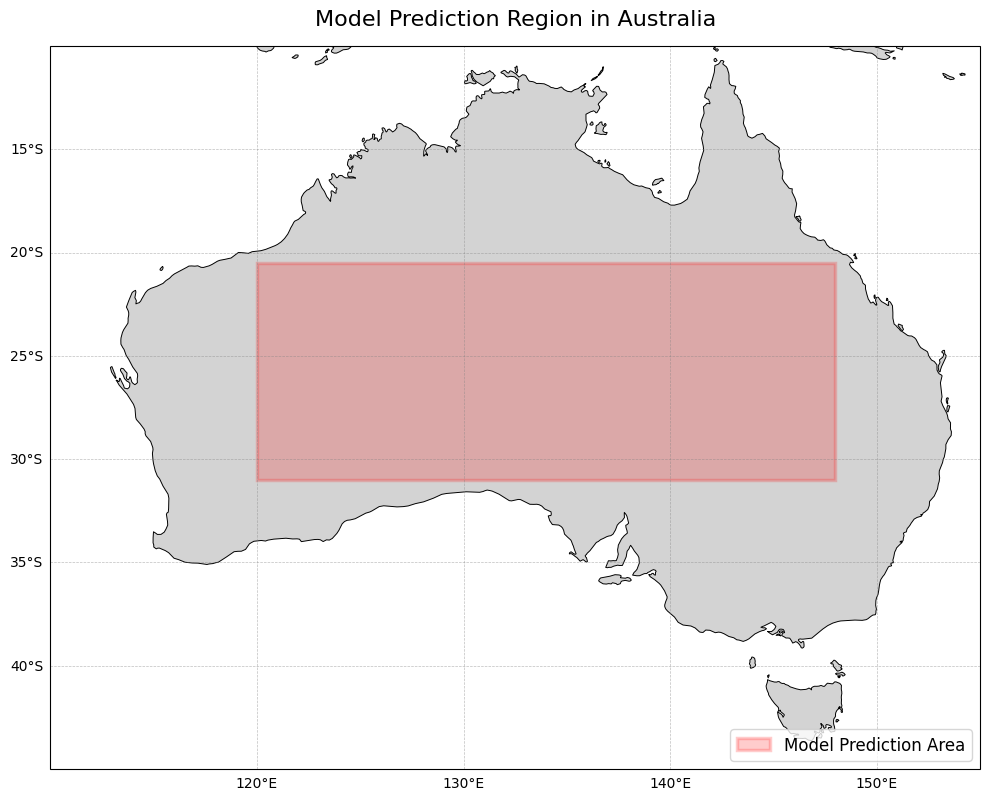

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent to show all of Australia
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')

# Model prediction area
rect = Rectangle(
    (area[1], area[2]),               # (longitude, latitude)
    area[3] - area[1],                # width (longitude span)
    area[0] - area[2],                # height (latitude span)
    linewidth=2.5,
    edgecolor='red',
    facecolor='red',
    alpha=0.2,
    transform=ccrs.PlateCarree(),
    label='Model Prediction Area'
)
ax.add_patch(rect)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title("Model Prediction Region in Australia", fontsize=16, pad=15)
plt.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

plt.savefig("prediction_region_map.png", dpi=300, bbox_inches='tight')


In [ ]:
# TRAINING DATA
for year in [1999, 2000, 2001]:
    ds = tf_monthly_dataset(year, input_variables, target_variables,
                            aggregation_dict, area, spei_data_path,
                            max_days, block_width, block_height)

    examples = list(ds.as_numpy_iterator())
    X = tf.stack([ex[0] for ex in examples]).numpy()
    y = tf.stack([ex[1] for ex in examples]).numpy()

    np.save(f"/content/drive/MyDrive/ST456/raw_train_X_{year}.npy", X)
    np.save(f"/content/drive/MyDrive/ST456/raw_train_y_{year}.npy", y)

2025-04-29 13:45:19,056 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:45:19,058 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:45:19,059 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:45:19,989 INFO Request ID is 49c657af-edf5-4541-9f68-5217a15e26c8
INFO:datapi.legacy_api_client:Request ID is 49c657af-edf5-4541-9f68-5217a15e26c8
2025-04-29 13:45:20,243 I

84265051c34320e43a3b4e82bc348867.nc:   0%|          | 0.00/78.5M [00:00<?, ?B/s]

2025-04-29 13:48:31,451 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:48:31,452 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:48:31,454 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:48:32,654 INFO Request ID is 667379a2-0274-427f-984d-2765ace14521
INFO:datapi.legacy_api_client:Request ID is 667379a2-0274-427f-984d-2765ace14521
2025-04-29 13:48:32,913 I

b04e6dbf4e40abc36c70b895fdb65eed.nc:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

2025-04-29 13:49:14,305 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:49:14,306 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:49:14,307 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:49:15,466 INFO Request ID is c84d7089-87ef-4291-80ff-711a16ec89a0
INFO:datapi.legacy_api_client:Request ID is c84d7089-87ef-4291-80ff-711a16ec89a0
2025-04-29 13:49:15,707 I

7117fa25cc933b200d335d48ba99907c.nc:   0%|          | 0.00/102M [00:00<?, ?B/s]

2025-04-29 13:50:37,491 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:50:37,492 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:50:37,493 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:50:38,591 INFO Request ID is 5c619b68-86ff-4871-a469-0c7a62f4d64a
INFO:datapi.legacy_api_client:Request ID is 5c619b68-86ff-4871-a469-0c7a62f4d64a
2025-04-29 13:50:38,845 I

c99532a983272394fb441092892e6d19.nc:   0%|          | 0.00/79.6M [00:00<?, ?B/s]

2025-04-29 13:51:20,612 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:51:20,613 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:51:20,614 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:51:22,168 INFO Request ID is fcd21c05-7a39-42a3-a5af-19ce41c8d298
INFO:datapi.legacy_api_client:Request ID is fcd21c05-7a39-42a3-a5af-19ce41c8d298
2025-04-29 13:51:22,673 I

8c970509fa2a785580c7f1300af63c40.nc:   0%|          | 0.00/87.4M [00:00<?, ?B/s]

2025-04-29 13:51:57,185 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:51:57,186 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:51:57,188 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:51:58,467 INFO Request ID is cd2d27fa-43d8-4e04-b033-79754a7a8a09
INFO:datapi.legacy_api_client:Request ID is cd2d27fa-43d8-4e04-b033-79754a7a8a09
2025-04-29 13:51:58,706 I

98f7ecc75d529e3383515de011752b52.nc:   0%|          | 0.00/89.3M [00:00<?, ?B/s]

2025-04-29 13:52:44,395 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:52:44,396 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:52:44,397 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:52:45,704 INFO Request ID is 958aa892-7954-4a51-b5b5-6b5ac148ba63
INFO:datapi.legacy_api_client:Request ID is 958aa892-7954-4a51-b5b5-6b5ac148ba63
2025-04-29 13:52:45,947 I

4ace31a6f7d68c070e59eb8a2fdeeb6c.nc:   0%|          | 0.00/72.3M [00:00<?, ?B/s]

2025-04-29 13:53:42,002 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:53:42,003 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:53:42,004 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:53:44,144 INFO Request ID is 958d9f5e-871e-49b5-849f-28c730fe8f18
INFO:datapi.legacy_api_client:Request ID is 958d9f5e-871e-49b5-849f-28c730fe8f18
2025-04-29 13:53:44,380 I

332db56d3b07e84e9aae66cfc41a53ef.nc:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

2025-04-29 13:54:25,058 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 13:54:25,060 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 13:54:25,061 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 13:54:26,345 INFO Request ID is adffe811-23c1-4e10-beed-1b7b35db6027
INFO:datapi.legacy_api_client:Request ID is adffe811-23c1-4e10-beed-1b7b35db6027
2025-04-29 13:54:26,590 I

4ff2b47e7ae8e404c9009dc9a7d2963f.nc:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

2025-04-29 14:05:01,990 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 14:05:01,992 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 14:05:01,993 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 14:05:03,531 INFO Request ID is c38b141c-f6dd-4389-b7d8-0127d7fd266b
INFO:datapi.legacy_api_client:Request ID is c38b141c-f6dd-4389-b7d8-0127d7fd266b
2025-04-29 14:05:03,772 I

9e7ac19afc643d6adcefafbfc3a0c70d.nc:   0%|          | 0.00/110M [00:00<?, ?B/s]

2025-04-29 14:15:47,293 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 14:15:47,294 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 14:15:47,295 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 14:15:48,186 INFO Request ID is c94e3704-8a90-4a36-ae4c-13e99f7b5157
INFO:datapi.legacy_api_client:Request ID is c94e3704-8a90-4a36-ae4c-13e99f7b5157
2025-04-29 14:15:48,460 I

f2bd6e388b9f235f5a14a39eced61d94.nc:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

2025-04-29 14:18:14,017 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 14:18:14,018 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 14:18:14,019 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 14:18:15,402 INFO Request ID is fba89f78-6149-4598-874b-3164abf9e594
INFO:datapi.legacy_api_client:Request ID is fba89f78-6149-4598-874b-3164abf9e594
2025-04-29 14:18:15,637 I

90e7e11ac03f42850919fe64551be99b.nc:   0%|          | 0.00/83.7M [00:00<?, ?B/s]

2025-04-29 14:31:23,062 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 14:31:23,063 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 14:31:23,065 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 14:31:24,155 INFO Request ID is defe9f99-60f5-4f06-bb47-512ccb90cfe9
INFO:datapi.legacy_api_client:Request ID is defe9f99-60f5-4f06-bb47-512ccb90cfe9
2025-04-29 14:31:24,406 I

4dd878725737cce651f5bd17f3915e27.nc:   0%|          | 0.00/91.8M [00:00<?, ?B/s]

2025-04-29 14:32:19,969 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 14:32:19,970 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 14:32:19,971 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 14:32:22,888 INFO Request ID is 9683b27f-2adb-437a-8c15-854a296ac467
INFO:datapi.legacy_api_client:Request ID is 9683b27f-2adb-437a-8c15-854a296ac467
2025-04-29 14:32:23,154 I

daeb57e656d80637c49b2773abdb76ed.nc:   0%|          | 0.00/64.3M [00:00<?, ?B/s]

In [ ]:
# Combining Training Data
X_1999 = np.load("/content/drive/MyDrive/ST456/raw_train_X_1999.npy")
X_2000 = np.load("/content/drive/MyDrive/ST456/raw_train_X_2000.npy")
X_2001 = np.load("/content/drive/MyDrive/ST456/raw_train_X_2001.npy")
y_1999 = np.load("/content/drive/MyDrive/ST456/raw_train_y_1999.npy")
y_2000 = np.load("/content/drive/MyDrive/ST456/raw_train_y_2000.npy")
y_2001 = np.load("/content/drive/MyDrive/ST456/raw_train_y_2001.npy")

train_X = np.concatenate([X_1999, X_2000, X_2001], axis=0)
train_y = np.concatenate([y_1999, y_2000, y_2001], axis=0)

In [ ]:
# Save combined raw training data
np.save('/content/drive/MyDrive/ST456/raw_train_X_combined.npy', train_X)
np.save('/content/drive/MyDrive/ST456/raw_train_y_combined.npy', train_y)

In [ ]:
# TESTING DATA
test_dataset = tf_monthly_dataset(test_year, input_variables, target_variables, aggregation_dict, area, spei_data_path, max_days, block_width, block_height)

all_test_examples = list(test_dataset.as_numpy_iterator())

test_X = tf.stack([ex[0] for ex in all_test_examples])
test_y = tf.stack([ex[1] for ex in all_test_examples])

2025-04-29 14:37:33,812 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 14:37:33,814 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 14:37:33,815 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 14:37:35,042 INFO Request ID is 948cd4d1-d1c6-483e-bf26-a0fa2e56781d
INFO:datapi.legacy_api_client:Request ID is 948cd4d1-d1c6-483e-bf26-a0fa2e56781d
2025-04-29 14:37:35,290 I

e20c1638980db66b0134b58a5dd81b75.nc:   0%|          | 0.00/79.4M [00:00<?, ?B/s]

2025-04-29 14:48:11,917 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 14:48:11,918 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 14:48:11,919 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 14:48:13,554 INFO Request ID is adb540a9-b0cf-4eac-a0a0-7758840c5380
INFO:datapi.legacy_api_client:Request ID is adb540a9-b0cf-4eac-a0a0-7758840c5380
2025-04-29 14:48:13,832 I

3a0c17e9774fe14b269e7d4cdd5b622c.nc:   0%|          | 0.00/9.40M [00:00<?, ?B/s]

2025-04-29 14:58:43,886 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 14:58:43,887 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 14:58:43,888 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 14:58:45,047 INFO Request ID is d0ab37fb-a5bc-4061-b1cb-8465f54cae17
INFO:datapi.legacy_api_client:Request ID is d0ab37fb-a5bc-4061-b1cb-8465f54cae17
2025-04-29 14:58:45,303 I

a0980170e71d2975c0bc9d4ab1b372ae.nc:   0%|          | 0.00/110M [00:00<?, ?B/s]

2025-04-29 15:11:41,963 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 15:11:41,964 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 15:11:41,965 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 15:11:42,875 INFO Request ID is caadbcbe-87ab-4735-b7dd-c7065c68892d
INFO:datapi.legacy_api_client:Request ID is caadbcbe-87ab-4735-b7dd-c7065c68892d
2025-04-29 15:11:43,128 I

766cc02616f32e02d94dc51d0250360.nc:   0%|          | 0.00/82.7M [00:00<?, ?B/s]

2025-04-29 15:28:27,303 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 15:28:27,304 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 15:28:27,306 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 15:28:28,246 INFO Request ID is 424f2047-acd2-4e34-9867-7d958ecd1b93
INFO:datapi.legacy_api_client:Request ID is 424f2047-acd2-4e34-9867-7d958ecd1b93
2025-04-29 15:28:28,517 I

44b4765b51b87905acf644f9251a974d.nc:   0%|          | 0.00/82.6M [00:00<?, ?B/s]

2025-04-29 15:41:04,815 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 15:41:04,816 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 15:41:04,817 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 15:41:05,708 INFO Request ID is 9e7f19c7-fadd-45a4-8b93-3a3f0be2847d
INFO:datapi.legacy_api_client:Request ID is 9e7f19c7-fadd-45a4-8b93-3a3f0be2847d
2025-04-29 15:41:05,979 I

8e6af00f366bfdc5018f757145f5740c.nc:   0%|          | 0.00/89.9M [00:00<?, ?B/s]

2025-04-29 15:53:45,988 WARNING [2025-04-29T00:00:00] Multiple maintenance sessions are planned this week, which may affect data downloads and other services. Check [here](https://status.ecmwf.int/) for status updates.
2025-04-29 15:53:45,990 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-29 15:53:45,991 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-29 15:53:47,734 INFO Request ID is 59de1a41-56bc-4f6d-9d46-1057bf56b0dc
INFO:datapi.legacy_api_client:Request ID is 59de1a41-56bc-4f6d-9d46-1057bf56b0dc
2025-04-29 15:53:48,563 I

5e7c9596d4544cd561d9b3f227e5c040.nc:   0%|          | 0.00/59.7M [00:00<?, ?B/s]

In [ ]:
# Save raw test data
np.save(f'{SAVE_DIR}/raw_test_X.npy', test_X.numpy())
np.save(f'{SAVE_DIR}/raw_test_y.npy', test_y.numpy())